# Data Visualisation, Prepocessing and Some Baseline Models

---



In [1]:
import numpy as np
import datetime as dt
import pandas
import time
import random
import matplotlib
import pandas as pd
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

In [2]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [3]:
# Code snippet taken from class material
def getfile(gdrive,**kwargs): #tries to get local version and then defaults to google drive version
    loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
    out=pandas.read_pickle(loc, **kwargs)
    return out

### Import the Features
Here we import the features saved as binary files in the project folder. We have identified that gasoline prices are primarily driven by classical economic theory of supply and demand. The supply of gasoline to the US is primarily from domestic crude oil wells and imports from other nations. The US also maintains a strategic petroleum reserve to handle the disruptions in the crude oil supply chain. Demand of gasoline is primarily reflected by domestic consumption. Other than these, inflation limits the purchasing power thus affecting both production/import and consumtion of gasoline. It is usually measured as Consumer Price Index (CPI) by the Federal Bank of the US. Further, changes in taxation at federal and state level will also impact the prices, however it remains constant over a long duration. Finally, we will also use historical trends in gasoline prices to capture any missing features. To summarize, we are building a Recurrent Neural Network (RNN) to predict the weekly gasoline price based on the following features:


1.   Weekly crude oil import (Supply)
2.   Strategic Petroleum Reserve (Supply)
3.   Domestic Production (Supply)
4.   Domestic Consumption of Gas (Demand)
5.   Domestic Inflation as CPI
6.   Historical Price of Gasoline

We first load the data from pickle files saved on the google drive folder.

In [4]:
data = {}

# CPI
fname = "https://drive.google.com/file/d/1-CKtjFCPXvt1VHtMGhIZX3ew0yGD4kqA/view?usp=share_link"
data['CPI'] = getfile(fname)
data['CPI'] = data['CPI'].reset_index(drop=True)
data['CPI'] = data['CPI'].rename(columns={"Yearmon": "Date"})
data['CPI']['Date'] = data['CPI']['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m'))
data['CPI']['Date'] = pandas.to_datetime(data['CPI']['Date'])
print(data['CPI'].head())

# Consumption
fname = "https://drive.google.com/file/d/196YZI2degsMUuY2B_dGedX2dn7YqN8eA/view?usp=share_link"
data['Consumption'] = getfile(fname)
data['Consumption'] = data['Consumption'].rename(columns={"Week of": "Date"})
print(data['Consumption'].head())

# Price
fname = "https://drive.google.com/file/d/1xZTHOvRw8dI2ZOQ2GQqa5TeEV9m7WLZ0/view?usp=share_link"
data['Price'] = getfile(fname)
print(data['Price'].head())

# Imports
fname = "https://drive.google.com/file/d/10WJGO-BH3OLLMHHVtHHek4O-odPvsJyP/view?usp=share_link"
data['NetImports'] = getfile(fname)
print(data['NetImports'].head())

# Reserve
fname = "https://drive.google.com/file/d/1TK9W9xA9tOH5qfjlmbh49L13Grj52u6f/view?usp=share_link"
data['Reserve'] = getfile(fname)[::-1]
data['Reserve'] = data['Reserve'].rename(columns={"Month": "Date"})
print(data['Reserve'].head())

# Production
fname = "https://drive.google.com/file/d/12RZ5g-tlhVPQH5hMEgMoJOXFtXG_cL35/view?usp=share_link"
data['Production'] = getfile(fname)[::-1]
data['Production'] = data['Production'].rename(columns={"Month": "Date"})
print(data['Production'].head())

        Date   CPI
0 1975-07-01  54.2
1 1975-08-01  54.3
2 1975-09-01  54.6
3 1975-10-01  54.9
4 1975-11-01  55.3
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Product Supplied of Finished Motor Gasoline Thousand Barrels per Day  
0                                               6621                                 
1                                               6433                                 
2                                               6582                                 
3                                               7224                                 
4                                               6875                                 
        Date  Price
0 1993-04-05  1.068
1 1993-04-12  1.079
2 1993-04-19  1.079
3 1993-04-26  1.086
4 1993-05-03  1.086
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Net Imports of Crude Oil and Petroleum Pr

### Find a common starting time for all data

We then truncate the data based on the available price data. We discard all of the data with an earlier date than the date of the first price data point.

In [5]:
for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
  data[feature] = data[feature].loc[data[feature].iloc[: , 0] > (data['Price'].iloc[0 , 0] - pandas.offsets.Day(12))].reset_index(drop=True)

### Match features to the price data

Next, we match each price data-point with the feature data-points which have a date closest to the date of the price data-point. We note that we only consider feature data-points with an earlier date.

In [6]:
data_list = []
for index, row in data['Price'].iterrows():
  for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
    x = data[feature].loc[(data[feature]['Date'] < row['Date'])]
    row[feature] = x.loc[(x['Date'] - row['Date']).abs().idxmin()].iloc[1]

  data_list.append(row)

### Convert dataset into a Pandas Data Frame

In [7]:
dataset = pandas.DataFrame(data_list)

### Visualize the dataset

z-scoring the data

In [8]:
dataset_norm = dataset.copy()
dataset_norm.iloc[: , 1:] = (dataset_norm.iloc[: , 1:] - dataset_norm.iloc[: , 1:].mean()) / dataset_norm.iloc[: , 1:].std()
(dataset_norm).head()

,Date,Price,Production,CPI,NetImports,Reserve,Consumption
0,1993-04-05,-1.315651,-0.209089,-1.664355,-0.303166,-0.972198,-2.669643
1,1993-04-12,-1.303821,-0.209089,-1.664355,0.076097,-0.972198,-2.921803
2,1993-04-19,-1.303821,-0.209089,-1.664355,-0.179352,-0.972198,-1.768210
3,1993-04-26,-1.296293,-0.209089,-1.664355,0.013277,-0.972198,-2.023389
4,1993-05-03,-1.296293,-0.124841,-1.659050,0.197825,-0.965331,-1.905614


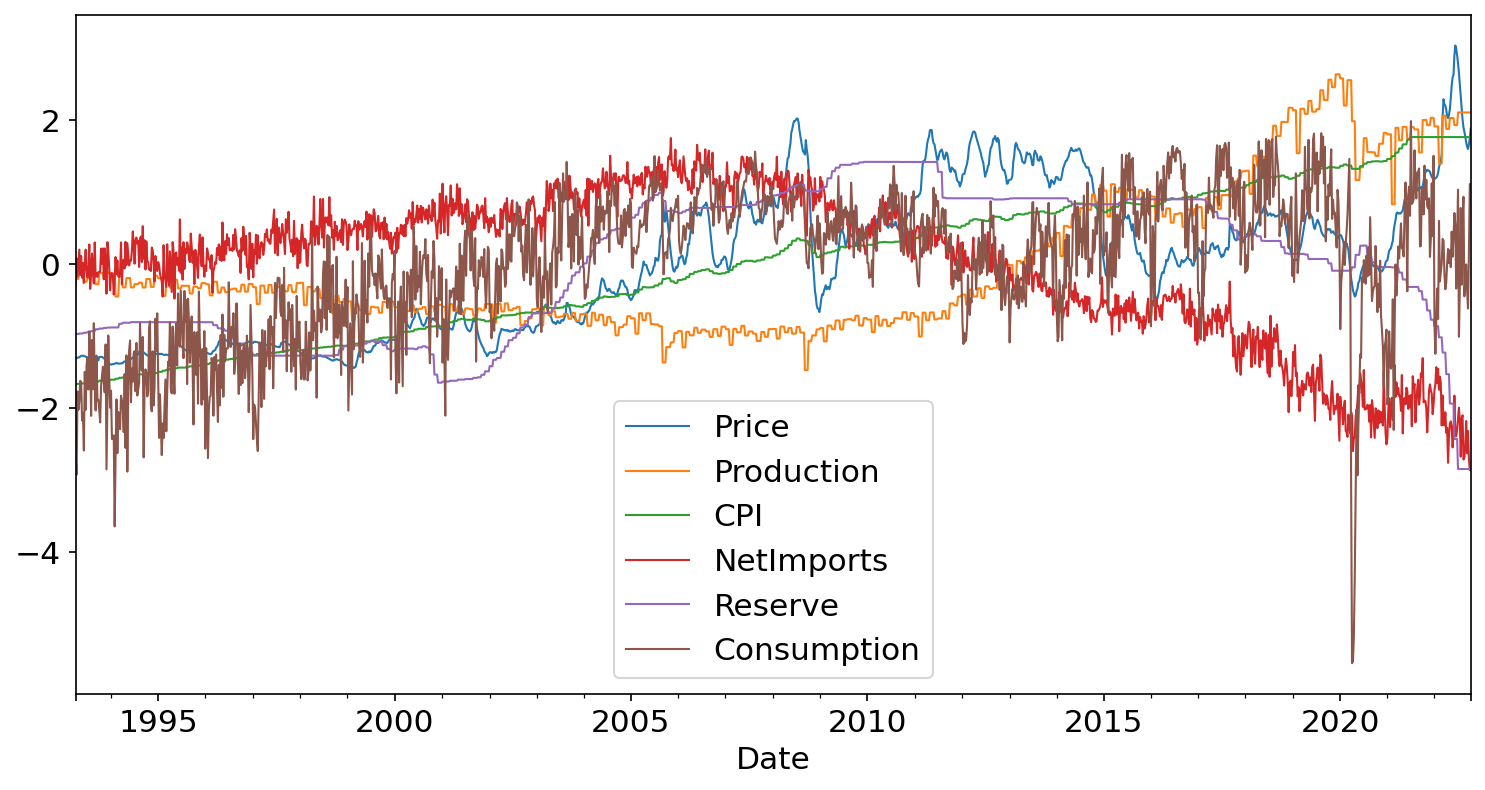

In [9]:
plt.figure(figsize=(12, 6), dpi=150)
df = dataset_norm.plot(x='Date', linewidth=1, ax = plt.gca())

# plt.plot(dataset.iloc[: , 0], (dataset.iloc[: , 1:] - dataset.iloc[: , 1:].mean()) / dataset.iloc[: , 1:].std(), linewidth=1)
# plt.legend()
# plt.show()

## Train-Val-Test Split

Before we extract any information from the data we split them into train, validation and test data. We take the last 10% of the data as the test set and 20% as the validation set. The analysis that follows is performed on the train data.

In [16]:
trainset = dataset[:-int(0.3 * len(dataset))].copy()
validationset = dataset[-int(0.3 * len(dataset)):-int(0.1 * len(dataset))].copy()
testset = dataset[-int(0.1 * len(dataset)):].copy()
trainset = trainset.drop(["Date"], axis = 1)
validationset = validationset.drop(["Date"], axis = 1)
testset = testset.drop(["Date"], axis = 1)
print("trainset length: "+ str(len(trainset))+ " | validationset length: " + str(len(validationset)) +  " | testset length: " + str(len(testset)) + " | Complete dataset length: " + str(len(dataset)))

trainset length: 1079 | validationset length: 308 | testset length: 154 | Complete dataset length: 1541


Normalize the train data, as well as the test, validation data based on the mean and std values of the train data.

In [17]:
from sklearn.preprocessing import StandardScaler

names = dataset.columns[1:len(dataset)]
scaler = StandardScaler()
scaler = scaler.fit(trainset)
train_df = pd.DataFrame(scaler.transform(trainset))
train_df.columns = names

test_df = pd.DataFrame(scaler.transform(testset))
test_df.columns = names

val_df = pd.DataFrame(scaler.transform(validationset))
val_df.columns = names

# Linear Regression Baseline

---



We use linear regression as a baseline model. First we train a linear regression model on the features which do not contain historic price data and then on the features containing the price of the previous week.


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import svm

y_train = train_df.iloc[: , 0].to_numpy()
X_train = train_df.iloc[: , 1:].to_numpy()

y_val = val_df.iloc[: , 0].to_numpy()
X_val = val_df.iloc[: , 1:].to_numpy()

y_test = test_df.iloc[: , 0].to_numpy()
X_test = test_df.iloc[: , 1:].to_numpy()

reg = LinearRegression().fit(X_train, y_train)
y_train_hat = reg.predict(X_train)
y_val_hat = reg.predict(X_val)
y_test_hat = reg.predict(X_test)

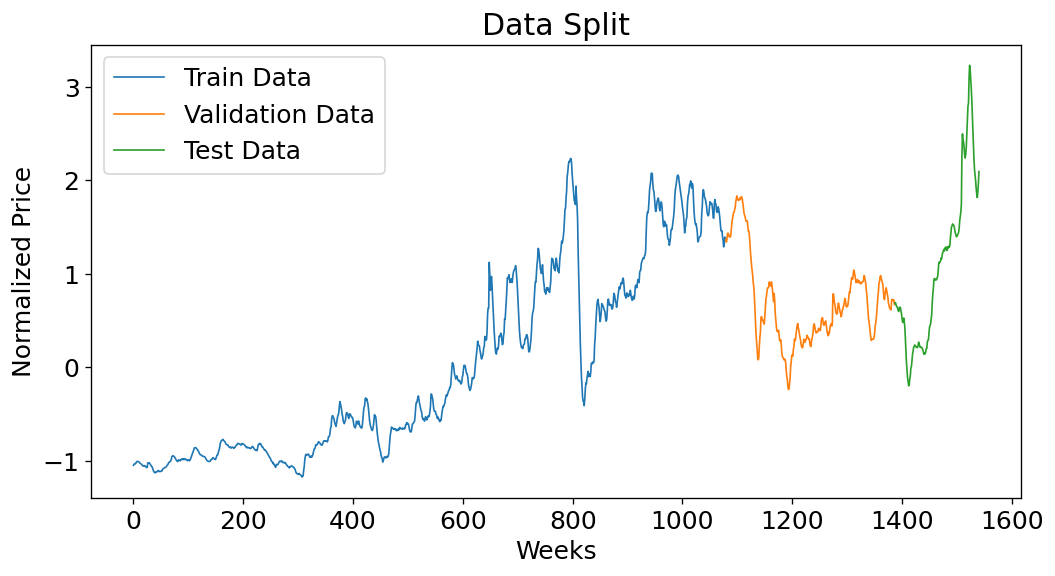

In [19]:
plt.figure(figsize=(10, 5), dpi=120)
plt.plot(y_train, linewidth=1, label='Train Data')
plt.plot(np.arange(len(y_val))+len(y_train), y_val, linewidth=1, label='Validation Data')
plt.plot(np.arange(len(y_test))+len(y_val)+len(y_train), y_test, linewidth=1, label='Test Data')
plt.title('Data Split')
plt.ylabel('Normalized Price')
plt.xlabel('Weeks')
plt.legend()
plt.show()

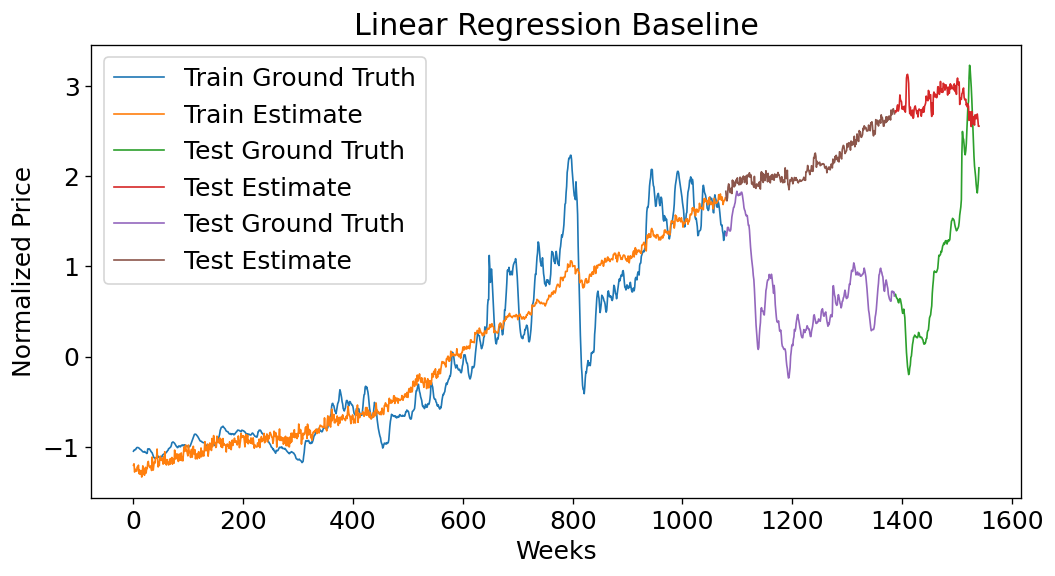

In [20]:
plt.figure(figsize=(10, 5), dpi=120)
plt.plot(y_train, linewidth=1, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_test))+len(y_val)+len(y_train), y_test, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_test))+len(y_val)+len(y_train), y_test_hat, linewidth=1, label='Test Estimate')
plt.plot(np.arange(len(y_val))+len(y_train), y_val, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_val))+len(y_train), y_val_hat, linewidth=1, label='Test Estimate')
plt.title('Linear Regression Baseline')
plt.ylabel('Normalized Price')
plt.xlabel('Weeks')
plt.legend()
plt.show()

Next we augment the features, by adding as a feature the price of the previous week. We observe that the performance is greatly improved both on the train set and test set.

In [21]:
shift = 1
train_df2 = pd.concat([train_df, train_df['Price'].shift(shift)], axis=1, ignore_index=True)[shift:]
y_train = train_df2.iloc[: , 0].to_numpy()
X_train = train_df2.iloc[: , 1:].to_numpy()

val_df2 = pd.concat([val_df, val_df['Price'].shift(shift)], axis=1, ignore_index=True)[shift:]
y_val = val_df2.iloc[: , 0].to_numpy()
X_val = val_df2.iloc[: , 1:].to_numpy()

test_df2 = pd.concat([test_df, test_df['Price'].shift(1)], axis=1, ignore_index=True)[shift:]
y_test = test_df2.iloc[: , 0].to_numpy()
X_test = test_df2.iloc[: , 1:].to_numpy()

reg = LinearRegression().fit(X_train, y_train)
y_train_hat = reg.predict(X_train)
y_val_hat = reg.predict(X_val)
y_test_hat = reg.predict(X_test)

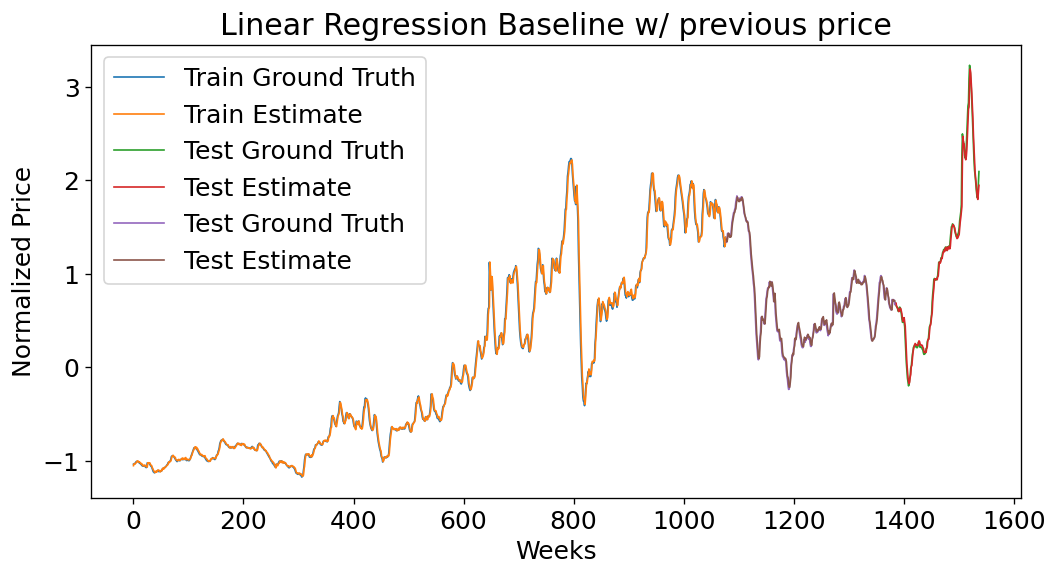

In [22]:
plt.figure(figsize=(10, 5), dpi=120)
plt.plot(y_train, linewidth=1, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_test))+len(y_val)+len(y_train), y_test, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_test))+len(y_val)+len(y_train), y_test_hat, linewidth=1, label='Test Estimate')
plt.plot(np.arange(len(y_val))+len(y_train), y_val, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_val))+len(y_train), y_val_hat, linewidth=1, label='Test Estimate')
plt.title('Linear Regression Baseline w/ previous price')
plt.ylabel('Normalized Price')
plt.xlabel('Weeks')
plt.legend()
plt.show()

In [23]:
print('Validation Mean Absolute Error:', np.abs(y_val - y_val_hat).mean())
print('Test Mean Absolute Error:', np.abs(y_test - y_test_hat).mean())
print()

print('Validation Mean Square Error:', ((y_val - y_val_hat)**2).mean())
print('Test Mean Square Error:', ((y_test - y_test_hat)**2).mean())

Validation Mean Absolute Error: 0.03784816857054502
Test Mean Absolute Error: 0.047719525795886585

Validation Mean Square Error: 0.0024413840187276934
Test Mean Square Error: 0.006221618641484361


The fact that the fitting improves substantially once historic data of the price itself is added as a feature shows the necessity of a long/short term memory of the price value